## Breast Cancer Prediction and Detection
### via Machine Learning and Deep Learning  

### David Kinney - DSC680 - Spring 2021 - Professor Catherine Williams
**********************************************************************

In [ ]:
# Import packages
import pandas as pd
from pycaret.classification import *

## Breast Cancer Prediction - Machine Learning

In [ ]:
# Read the Breast Cancer Wisconsin (Diagnostic) dataset
df = pd.read_csv('./data/data.csv')
df.shape

### Exploratory Data Analysis

In [ ]:
df.describe().T

In [ ]:
df.info()

In [ ]:
df.drop(['Unnamed: 32'], axis=1, inplace=True)

***********************************************
### Machine Learning Model Selection, Training and Tuning  

#### Initialize PyCaret

In [ ]:
clf1 = setup(df, target = 'diagnosis', 
             session_id=8784, 
             log_experiment=True, 
             experiment_name='BCpred')

#### Compare Baseline

In [ ]:
best_model = compare_models()

**Create best model from baseline results**

In [ ]:
model = create_model('xgboost', gpu_id=1)

**Tune hyperparameters**

In [ ]:
tuned_model = tune_model(model)

#### Plot Results

In [ ]:
plot_model(model)

In [ ]:
plot_model(model, plot = 'confusion_matrix')

In [ ]:
plot_model(model, plot = 'boundary')

In [ ]:
plot_model(model, plot = 'feature')

In [ ]:
plot_model(model, plot = 'pr')

In [ ]:
plot_model(model, plot = 'class_report')

In [ ]:
interpret_model(model)

In [ ]:
interpret_model(model, plot = 'correlation')

### Model Prediction

In [ ]:
pred_holdouts = predict_model(model)
pred_holdouts.head()

************************************
## Breast Cancer Detection - Deep Learning 
### with fastai

In [2]:
# Import packages
from os import listdir

import pandas as pd
import numpy as np

from fastai.callback.fp16 import *
from fastai.vision.all import *
from fastai import *
from fastai.metrics import error_rate

### Exploratory Data Analysis

In [3]:
path = "./data/images/IDC_regular_ps50_idx5"
files = get_image_files(path)
len(files)

277524

**Load training data**

In [4]:
pattern= r'([^/_]+).png$'
dls = ImageDataLoaders.from_path_re(path, files, pattern, item_tfms=Resize(50),
                                    bs=64, size=50, valid_pct=0.3, seed = 61)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


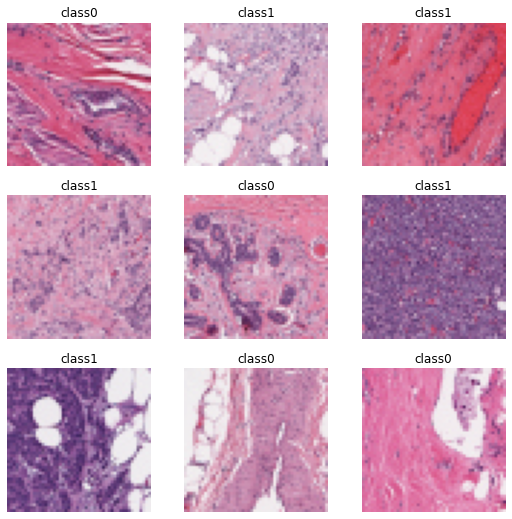

In [5]:
# Class 0 = benign, class 1 = malignant
dls.show_batch()

### Modeling 

I've been learning the [fastai](https://docs.fast.ai/) deep learning library, which also leverages `PyTorch`. The documentation is (IMHO) not well organized, but that is more than made up for with the online courses and the accompanying book. `fastai` streamlines much of the neural network modeling details, allowing me to simply supply model names such as `ResNet18` to the `cnn_learner` method. In addition, many of these models are pre-trained through *transfer learning*, requiring the model to only need to learn the weights of the last layer of the network.  

With transfer learning, we begin with an existing (trained) neural network used for image recognition and then tweak it a bit to train a model for a particular use case. Training a reasonable neural network would mean needing approximately 300,000 image samples, and to achieve really good performance, weâ€™re going to need at least a million images. For this use case, there are approximately 222,000 images in the training set. I am leveraging the `cnn_learner` function for loading a pre-trained ResNet18 network that was trained on around a million images from the ImageNet database.

**Approach**  

* Run 4 different training scenarios with a `ResNet18` model
* Take the best method, and train increasingly larger ResNets
* Evaluate results for best model

In [6]:
# fastai has a pretty cool feature that forces half-precision floating point
# precision training, effectively reducing GPU memory consumption: to_fp16
learn = cnn_learner(dls, models.resnet34, metrics=[accuracy]).to_fp16()

**As a baseline, I will run two different variations of the `fine-tune` method, which takes a pre-trained model and uses one epoch to fit just those parts necessary to fit my dataset.**

In [6]:
%%time
# Run a simple fine-tune for 5 epochs
learn.fine_tune(5)

Wall time: 2h 50min 36s


In [7]:
learn.save('BCPD_Simple5')

Path('data/images/IDC_regular_ps50_idx5/models/BCPD_Simple5.pth')

In [7]:
learn.load('BCPD_Simple5')

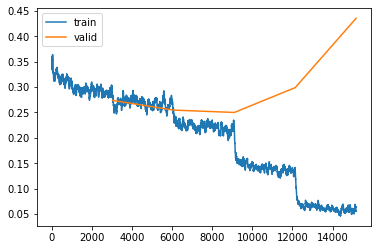

In [8]:
learn.recorder.plot_loss()

**Accuracy peaks at 3 epochs, so we only need to train that far. 89% accuracy is good, but I'd really like to see it break 90. I am going to retrain the model on only 3 epochs and then unfreeze all the weights and train the whole model again...**

In [11]:
%%time
# Run a simple fine-tune for 5 epochs
learn.fine_tune(3)

Wall time: 48min 5s


AttributeError: 'Sequential' object has no attribute 'plot'

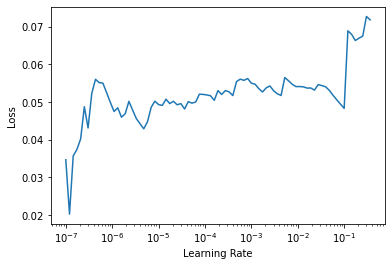

In [8]:
%%time
# Hypermaramter tuning
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [9]:
learn.fit_one_cycle(1,slice(1e-7,1e-5))

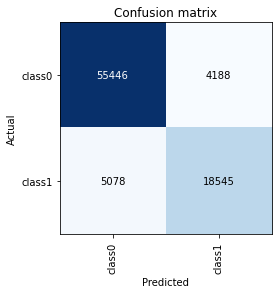

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

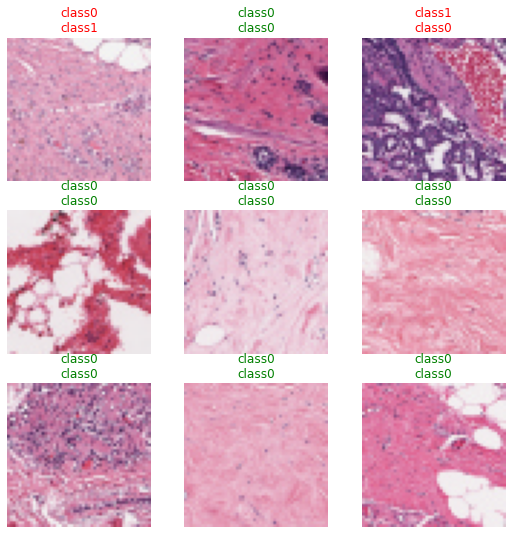

In [10]:
learn.show_results()

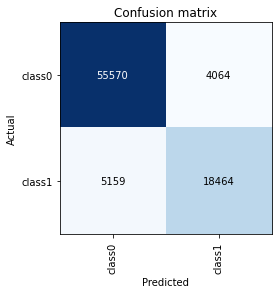

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [13]:
len(dls.valid_ds)

83257

In [14]:
5159+18464

23623

In [15]:
# Calculate sensitivity and specificity
upp, low = interp.confusion_matrix()
tn, fp = upp[0], upp[1]
fn, tp = low[0], low[1]

# Sensitivity = True Positive/(True Positive + False Negative)
sensitivity = tp/(tp + fn)

# Specificity = True Negative/(False Positive + True Negative)
# aka Type II error
specificity = tn/(fp + tn)

# Positive Predictive Value aka Type I error
ppv = tp/(tp+fp)

# Negative Predictive Value
npv = tn/(tn+fn)

# Accuracy: sensitivity x prevalence + specificity * (1 - prevalence)
val = dls.valid_ds.cat

"""
There are 23,623 class 1 images in the valid set (which has a total of 83,257 images 
and can be checked by using len(dls.valid_ds)) so the prevalence here 
is 15/50 = 0.3
"""
prevalence = 23623/83257

print("Sensitivity: {}".format(sensitivity))
print("Specificity: {}".format(specificity))
print
print("PPV: {}".format(ppv))
print("NPV: {}".format(npv))

Sensitivity: 0.7816111416839521
Specificity: 0.9318509575074622
PPV: 0.8196022727272727
NPV: 0.9150488234616081


#### Side notes on Results Evaluation

*(Note: this entire section was copied whole from [the fastai website](https://docs.fast.ai/tutorial.medical_imaging.html))* 

Medical models are predominantly high impact so it is important to know how good a model is at detecting a certain condition.

`Accuracy` can be defined as the number of correctly predicted data points out of all the data points. However in this context we can define accuracy as the probability that the model is correct and the patient has the condition PLUS the probability that the model is correct and the patient *does not* have the condition.

**Calculating Accuracy**

The accuracy of this model as mentioned before was 56% but how was this calculated? We can consider accuracy as:

**accuracy = sensitivity x prevalence + specificity * (1 - prevalence)**

Where **prevalence** is a statistical concept referring to the number of cases of a disease that are present in a particular population at a given time. The prevalence in this case is how many patients in the valid dataset have the condition compared to the total number.

There are some other key terms that need to be used when evaluating medical models:

**False Positive & False Negative**

* **False Positive** is an error in which a test result improperly indicates presence of a condition, such as a disease (the result is positive), when in reality it is not present
* **False Negative** is an error in which a test result improperly indicates no presence of a condition (the result is negative), when in reality it is present  

**Sensitivity & Specificity**

* **Sensitivity or True Positive Rate** is where the model classifies a patient has the disease given the patient actually does have the disease. Sensitivity quantifies the avoidance of false negatives  

Example: A new test was tested on 10,000 patients, if the new test has a sensitivity of 90% the test will correctly detect 9,000 (True Positive) patients but will miss 1000 (False Negative) patients that have the condition but were tested as not having the condition  

* **Specificity or True Negative Rate** is where the model classifies a patient as not having the disease given the patient actually does not have the disease. Specificity quantifies the avoidance of false positives  

[Understanding and using sensitivity, specificity and predictive values](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2636062/) is a great paper if you are interested in learning more about understanding sensitivity, specificity and predictive values.

**PPV and NPV**

Most medical testing is evaluated via PPV (Positive Predictive Value) or NPV (Negative Predictive Value).

**PPV** - if the model predicts a patient has a condition what is the probability that the patient actually has the condition

**NPV** - if the model predicts a patient does not have a condition what is the probability that the patient actually does not have the condition

The ideal value of the PPV, with a perfect test, is 1 (100%), and the worst possible value would be zero

The ideal value of the NPV, with a perfect test, is 1 (100%), and the worst possible value would be zero